In [4]:
import requests
from bs4 import BeautifulSoup
import json
import os
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold

c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def extrair_manchetes(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    manchetes = [titulo.text.strip() for titulo in soup.find_all('a', class_='feed-post-link')]
    return manchetes

url = 'https://g1.globo.com/rj/rio-de-janeiro/'
manchetes = extrair_manchetes(url)
print(manchetes)

["'Pai, pai', gritou menina de 12 anos ao ser baleada enquanto brincava na praça", 'RJ tem 21 crianças baleadas em 2024; menina que brincava na praça será enterrada neste sábado', 'Rio tem chance de recorde de calor e 14 praias próprias para banho neste sábado', 'VÍDEOS: RJ2 de sexta-feira, 6 de dezembro de 2024', 'Defensoria Pública do RJ pede indenização e descontos nas contas de consumidores prejudicados pela falta de água', 'Caso Marielle: MP recorre e pede aumento da pena de Lessa e Élcio', 'VÍDEOS: RJ1 de sexta-feira, 6 de dezembro de 2024', 'Homem suspeito de matar policial em Belford Roxo é preso pela Delegacia de Homicídios da Baixada']


In [12]:
genai.configure(api_key=os.environ["GEMINI_KEY"])
safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
}

In [13]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [38]:
persona = 'analista de notícias'
metaprompt = f"""
Imagine que você é um {persona}, especializado em avaliar conteúdos de notícias. Categorize cada título baseado em emoções como positivas, neutras e negativas.
Aqui estão exemplos de conteúdos os quais estão devidamente classificados relacionados à cada emoção. Classifique as emoções em APENAS Positiva, neutra e negativa.
Estruture sua resposta de maneira que sua resposta seja uma string contínua onde cada linha é formatada como "Sentimento: Manchete". Seguem exemplos:
- Positiva: "Time de futebol local vence campeonato trazendo alegria à população"
- Neutra: "Prefeitura organiza reunião para discussão de novas políticas"
- Negativa: "Fábrica vai à falência, levando à perda de empregos na comunidade"

Classifique a seguir os títulos:
"""

In [44]:
final_prompt = metaprompt + "\n".join(manchetes)

generation_config = {
    'temperature': 0.6,
    'top_p': 0.8,
    'top_k': 20,
    'max_output_tokens': 1000
}

response = model.generate_content(
    final_prompt,
    generation_config=generation_config,
    safety_settings=safety_settings
)

print(response.text)

Negativa:'Pai, pai', gritou menina de 12 anos ao ser baleada enquanto brincava na praça
Negativa:RJ tem 21 crianças baleadas em 2024; menina que brincava na praça será enterrada neste sábado
Neutra:Rio tem chance de recorde de calor e 14 praias próprias para banho neste sábado
Neutra:VÍDEOS: RJ2 de sexta-feira, 6 de dezembro de 2024
Positiva:Defensoria Pública do RJ pede indenização e descontos nas contas de consumidores prejudicados pela falta de água
Positiva:Caso Marielle: MP recorre e pede aumento da pena de Lessa e Élcio
Neutra:VÍDEOS: RJ1 de sexta-feira, 6 de dezembro de 2024
Positiva:Homem suspeito de matar policial em Belford Roxo é preso pela Delegacia de Homicídios da Baixada



In [47]:
model_response = (response.text)

In [48]:
sentiment_counts = {"Positive": 0, "Neutral": 0, "Negative": 0}
lines = model_response.strip().split("\n")
classified_headlines = []

In [ ]:
lines = model_response.strip().split("\n")
classified_headlines = []

for line in lines:
    index = line.find(':')
    if index != -1:
        sentiment = line[:index].strip()
        headline = line[index+1:].strip()  # +1 para remover o ':' da manchete
        classified_headlines.append({"headline": headline, "sentiment": sentiment})

In [50]:
json_output = json.dumps(classified_headlines, indent=4)

with open("classified_headlines.json", "w") as json_file:
    json_file.write(json_output)

print("JSON salvo com sucesso:", json_output)

JSON salvo com sucesso: [
    {
        "headline": "'Pai, pai', gritou menina de 12 anos ao ser baleada enquanto brincava na pra\u00e7a",
        "sentiment": "Negativa"
    },
    {
        "headline": "RJ tem 21 crian\u00e7as baleadas em 2024; menina que brincava na pra\u00e7a ser\u00e1 enterrada neste s\u00e1bado",
        "sentiment": "Negativa"
    },
    {
        "headline": "Rio tem chance de recorde de calor e 14 praias pr\u00f3prias para banho neste s\u00e1bado",
        "sentiment": "Neutra"
    },
    {
        "headline": "V\u00cdDEOS: RJ2 de sexta-feira, 6 de dezembro de 2024",
        "sentiment": "Neutra"
    },
    {
        "headline": "Defensoria P\u00fablica do RJ pede indeniza\u00e7\u00e3o e descontos nas contas de consumidores prejudicados pela falta de \u00e1gua",
        "sentiment": "Positiva"
    },
    {
        "headline": "Caso Marielle: MP recorre e pede aumento da pena de Lessa e \u00c9lcio",
        "sentiment": "Positiva"
    },
    {
        "headline

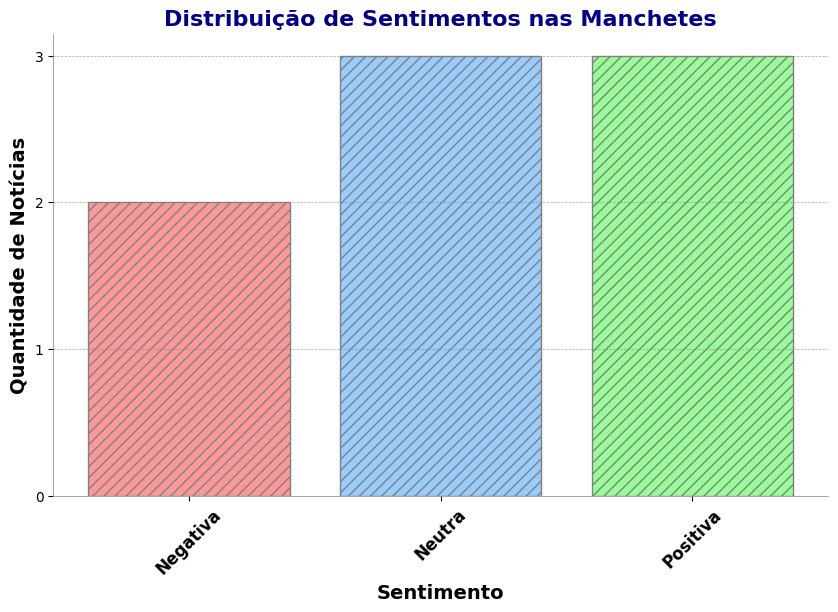

: 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

with open("classified_headlines.json", "r") as file:
    classified_headlines = json.load(file)

sentiment_counts = {"Negativa": 0, "Neutra": 0, "Positiva": 0}
for headline in classified_headlines:
    sentiment = headline["sentiment"]
    if sentiment in sentiment_counts:
        sentiment_counts[sentiment] += 1
    else:
        sentiment_counts[sentiment] = 1


categories = list(sentiment_counts.keys())
values = list(sentiment_counts.values())

colors = ['#FF9999', '#99CCFF', '#99FF99']  


plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors, edgecolor='grey')

for bar in bars:
    bar.set_hatch('///')

plt.title('Distribuição de Sentimentos nas Manchetes', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Sentimento', fontsize=14, fontweight='bold')
plt.ylabel('Quantidade de Notícias', fontsize=14, fontweight='bold')

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(rotation=45, fontsize=12, fontweight='bold')

plt.grid(color='gray', linestyle='dashed', linewidth=0.5, axis='y', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['bottom'].set_linewidth(0.5)

plt.show()

## **Interpretação do resultado:**

Avaliando o resultado gerado pelo modelo na classificação das manchetes, é evidente que a técnica de análise de sentimento empregada conseguiu categorizar as notícias em negativas, neutras e positivas com base no conteúdo emocional presente nos títulos. Essa habilidade de distinguir e categorizar sentimentos é fundamental para entender melhor a natureza das notícias e como elas podem afetar o público.

**Precisão na Categorização:** 

O modelo demonstrou uma compreensão adequada dos diferentes contextos emocionais das manchetes. Por exemplo, ele identificou corretamente as situações envolvendo violência e tragédias como negativas, o que reflete uma sensibilidade apropriada a temas de dor e perda. Igualmente, reconheceu as informações rotineiras ou informativas como neutras, e as ações que representam progresso ou resolução positiva de problemas como positivas.

**Implicações do Modelo:**

A capacidade do modelo de classificar essas manchetes ajuda não só na organização do conteúdo para os leitores, mas também na análise de tendências de cobertura de notícias. Isso pode ser particularmente útil para editores e gestores de conteúdo ao planejarem suas estratégias de comunicação e ao buscarem um equilíbrio na cobertura dada a eventos positivos e negativos. Além disso, tal análise pode auxiliar em pesquisas que investigam os efeitos da exposição a diferentes tipos de notícias no bem-estar dos consumidores de mídia.

**Limitações e Considerações Futuras:**

Embora o modelo tenha funcionado bem, é importante reconhecer que a análise de sentimentos pode às vezes simplificar a complexidade emocional das notícias. Além disso, a interpretação de alguns títulos pode ser subjetiva, onde o contexto mais amplo da notícia pode alterar a percepção do sentimento. Investigações futuras poderiam explorar métodos mais avançados que considerem não apenas o texto dos títulos, mas também o conteúdo da notícia para uma classificação mais precisa e contextualizada.

